# RBPF-KSC Diagnostic Analysis

Visualize filter performance: log-vol tracking, regime detection, surprise signals, and changepoint analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

In [2]:
# Load data - adjust path as needed
csv_path = Path('../rbpf_diagnostic.csv')  # or Path('../build/rbpf_diagnostic.csv')

if not csv_path.exists():
    # Try alternative locations
    alternatives = [
        Path('rbpf_diagnostic.csv'),
        Path('../rbpf_diagnostic.csv'),
        Path('../../rbpf_diagnostic.csv'),
        Path('../build/rbpf_diagnostic.csv'),
    ]
    for alt in alternatives:
        if alt.exists():
            csv_path = alt
            break
    else:
        raise FileNotFoundError(f"Cannot find rbpf_diagnostic.csv. Run bench_rbpf_ksc first.")

df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} observations from {csv_path}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 5000 observations from rbpf_diagnostic.csv
Columns: ['t', 'true_vol', 'est_vol_fast', 'est_vol_smooth', 'true_log_vol', 'est_log_vol_fast', 'est_log_vol_smooth', 'true_regime', 'est_regime_fast', 'est_regime_smooth', 'regime_confidence', 'surprise', 'entropy', 'vol_ratio', 'ess', 'detected', 'change_type']


,t,true_vol,est_vol_fast,est_vol_smooth,true_log_vol,est_log_vol_fast,est_log_vol_smooth,true_regime,est_regime_fast,est_regime_smooth,regime_confidence,surprise,entropy,vol_ratio,ess,detected,change_type
0,0,0.011750,0.012878,0.012878,-4.4439,-4.4129,-4.4129,0,0,0,0.261,0.6269,1.3845,1.0258,199.7,0,0
1,1,0.011124,0.013290,0.013290,-4.4986,-4.4016,-4.4016,0,0,0,0.297,1.9313,1.3628,1.0523,188.2,0,0
2,2,0.011713,0.012731,0.012731,-4.4470,-4.4536,-4.4536,0,0,0,0.386,2.2260,1.2736,1.0708,157.5,0,0
3,3,0.011783,0.012544,0.012544,-4.4411,-4.4667,-4.4667,0,0,0,0.436,0.9049,1.2267,1.0854,133.5,0,0
4,4,0.011221,0.013317,0.012878,-4.4900,-4.4034,-4.4129,0,0,0,0.261,0.7245,1.1938,1.1051,129.0,0,0


## 1. Main Diagnostic Plot

Five-panel view: log-vol tracking (fast vs smooth), regime, confidence, surprise, ESS

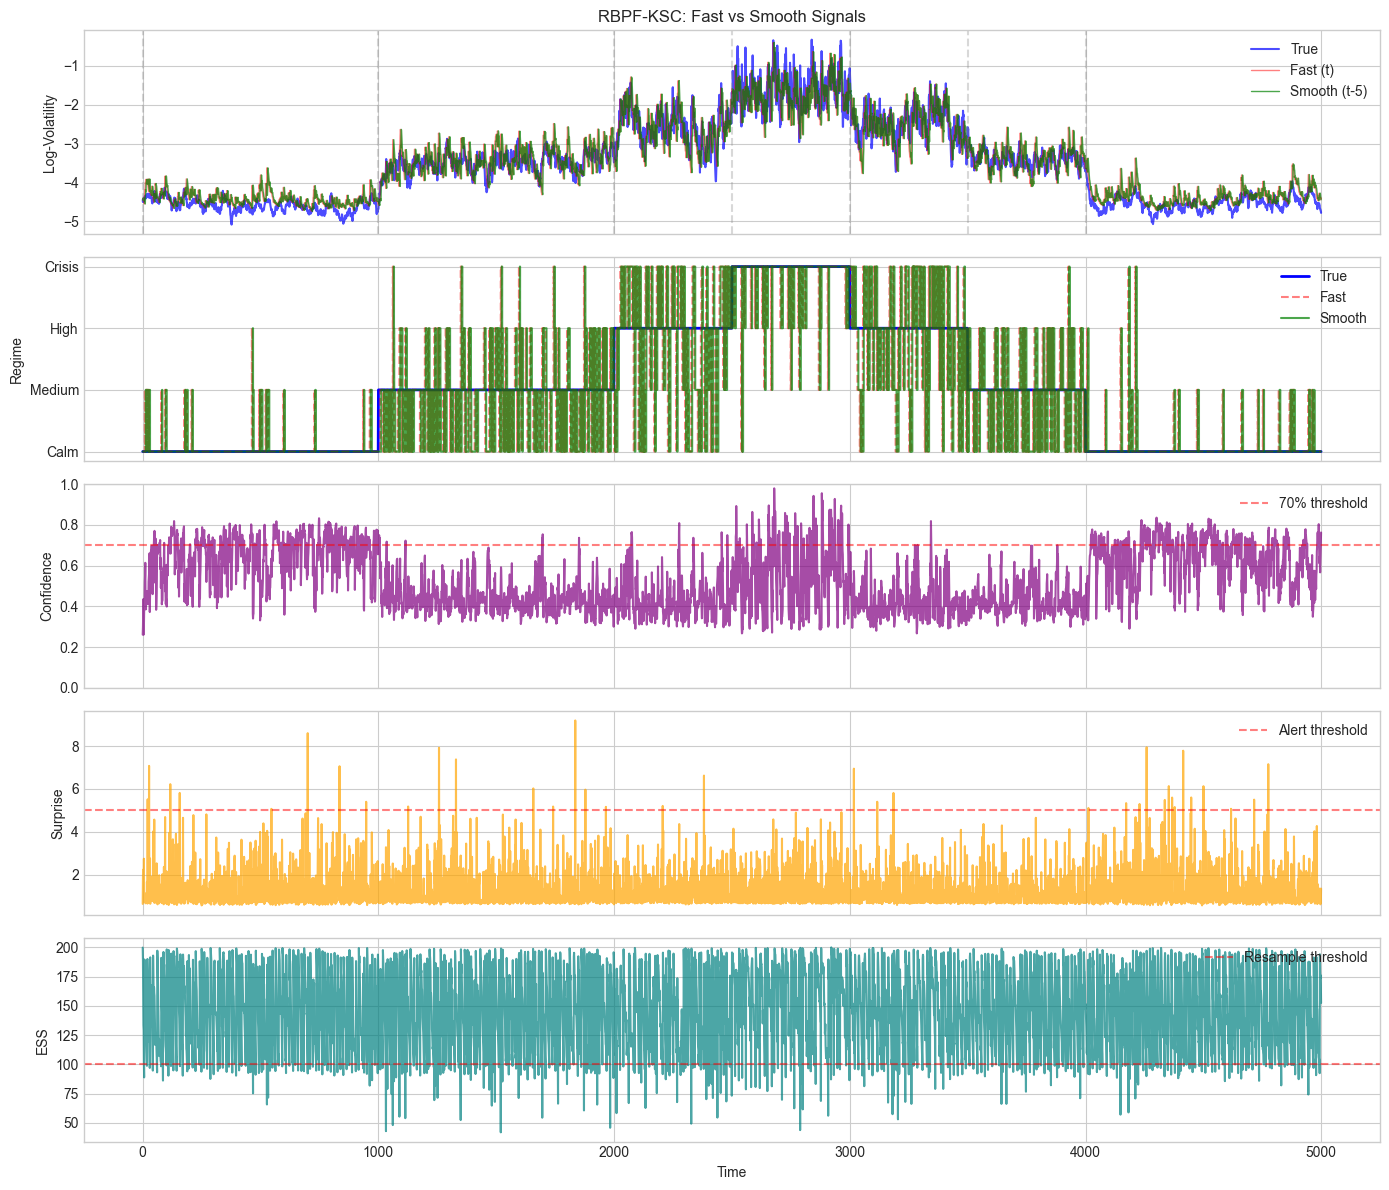

In [3]:
# Find regime changes for vertical lines
regime_changes = df[df['true_regime'].diff() != 0]['t'].tolist()

fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

# Log-vol tracking (fast vs smooth)
ax = axes[0]
ax.plot(df['t'], df['true_log_vol'], 'b-', alpha=0.7, linewidth=1.5, label='True')
ax.plot(df['t'], df['est_log_vol_fast'], 'r-', alpha=0.5, linewidth=1, label='Fast (t)')
ax.plot(df['t'], df['est_log_vol_smooth'], 'g-', alpha=0.7, linewidth=1, label='Smooth (t-5)')
ax.set_ylabel('Log-Volatility')
ax.legend(loc='upper right')
ax.set_title('RBPF-KSC: Fast vs Smooth Signals')
for t in regime_changes:
    ax.axvline(x=t, color='gray', linestyle='--', alpha=0.3)

# Regime (fast vs smooth)
ax = axes[1]
ax.plot(df['t'], df['true_regime'], 'b-', lw=2, label='True')
ax.step(df['t'], df['est_regime_fast'], 'r--', alpha=0.5, where='post', label='Fast')
ax.step(df['t'], df['est_regime_smooth'], 'g-', alpha=0.7, where='post', label='Smooth')
ax.set_ylabel('Regime')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['Calm', 'Medium', 'High', 'Crisis'])
ax.legend(loc='upper right')

# Regime confidence
ax = axes[2]
ax.plot(df['t'], df['regime_confidence'], 'purple', alpha=0.7)
ax.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='70% threshold')
ax.set_ylabel('Confidence')
ax.set_ylim([0, 1])
ax.legend(loc='upper right')

# Surprise
ax = axes[3]
ax.plot(df['t'], df['surprise'], 'orange', alpha=0.7)
ax.axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Alert threshold')
ax.set_ylabel('Surprise')
ax.legend(loc='upper right')

# ESS
ax = axes[4]
ax.plot(df['t'], df['ess'], 'teal', alpha=0.7)
ax.axhline(y=100, color='r', linestyle='--', alpha=0.5, label='Resample threshold')
ax.set_ylabel('ESS')
ax.set_xlabel('Time')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('rbpf_diagnostic_main.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Volatility Tracking Detail

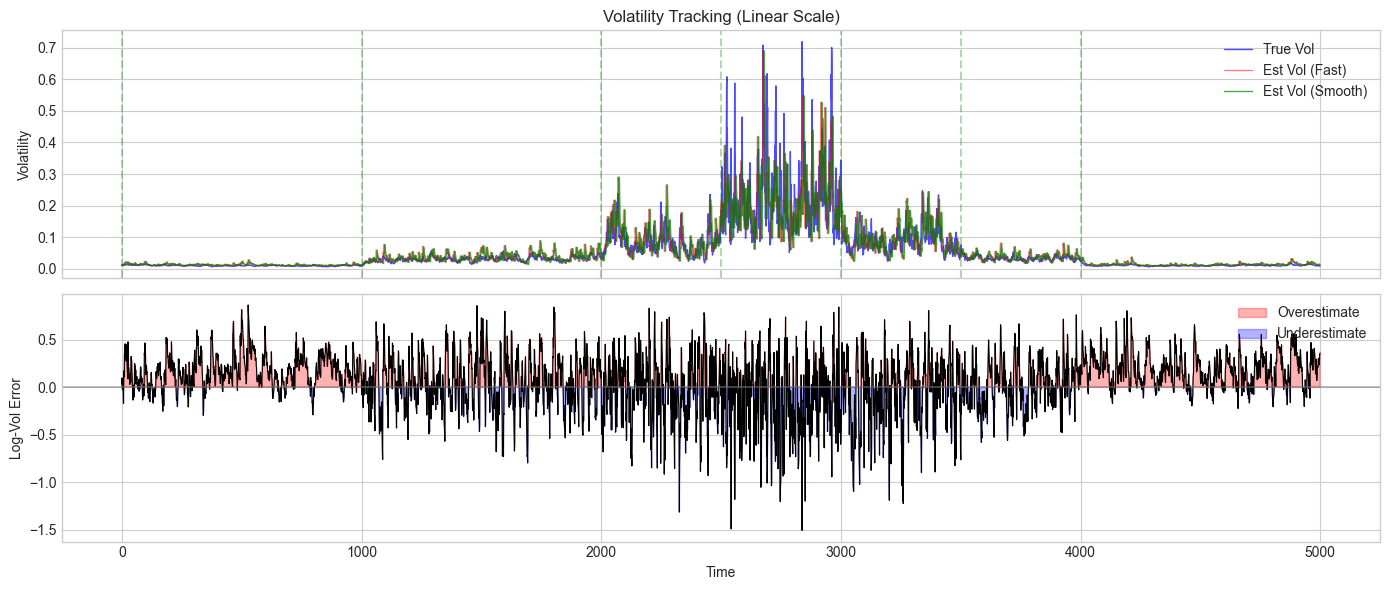

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Linear scale volatility
ax = axes[0]
ax.plot(df['t'], df['true_vol'], 'b-', alpha=0.7, linewidth=1, label='True Vol')
ax.plot(df['t'], df['est_vol_fast'], 'r-', alpha=0.5, linewidth=1, label='Est Vol (Fast)')
ax.plot(df['t'], df['est_vol_smooth'], 'g-', alpha=0.7, linewidth=1, label='Est Vol (Smooth)')
ax.set_ylabel('Volatility')
ax.legend(loc='upper right')
ax.set_title('Volatility Tracking (Linear Scale)')
for t in regime_changes:
    ax.axvline(x=t, color='green', linestyle='--', alpha=0.3)

# Tracking error (using fast signal)
ax = axes[1]
error = df['est_log_vol_fast'] - df['true_log_vol']
ax.plot(df['t'], error, 'k-', linewidth=0.8)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax.fill_between(df['t'], 0, error, where=error > 0, alpha=0.3, color='red', label='Overestimate')
ax.fill_between(df['t'], 0, error, where=error < 0, alpha=0.3, color='blue', label='Underestimate')
ax.set_ylabel('Log-Vol Error')
ax.set_xlabel('Time')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('rbpf_diagnostic_vol.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Changepoint Analysis

In [5]:
# Find true changepoints
changepoints = []
prev_regime = df['true_regime'].iloc[0]

for t in range(1, len(df)):
    curr_regime = df['true_regime'].iloc[t]
    if curr_regime != prev_regime:
        changepoints.append({
            't': t,
            'from_regime': prev_regime,
            'to_regime': curr_regime,
            'est_regime_fast': df['est_regime_fast'].iloc[t],
            'est_regime_smooth': df['est_regime_smooth'].iloc[t],
            'surprise': df['surprise'].iloc[t],
            'entropy': df['entropy'].iloc[t],
            'vol_ratio': df['vol_ratio'].iloc[t],
            'regime_confidence': df['regime_confidence'].iloc[t],
            'detected': df['detected'].iloc[t]
        })
        prev_regime = curr_regime

cp_df = pd.DataFrame(changepoints)
print("True Changepoints:")
cp_df

True Changepoints:


,t,from_regime,to_regime,est_regime_fast,est_regime_smooth,surprise,entropy,vol_ratio,regime_confidence,detected
0,1000,0,1,0,0,0.6895,0.8068,0.9857,0.733,0
1,2000,1,2,1,1,0.8423,1.1512,1.1715,0.403,0
2,2500,2,3,3,3,0.9911,1.1263,1.4679,0.423,0
3,3000,3,2,3,3,0.7308,1.0199,0.8880,0.544,0
4,3500,2,1,1,1,0.7074,1.2266,0.5904,0.373,0
5,4000,1,0,0,0,0.8321,1.2318,0.9186,0.409,0


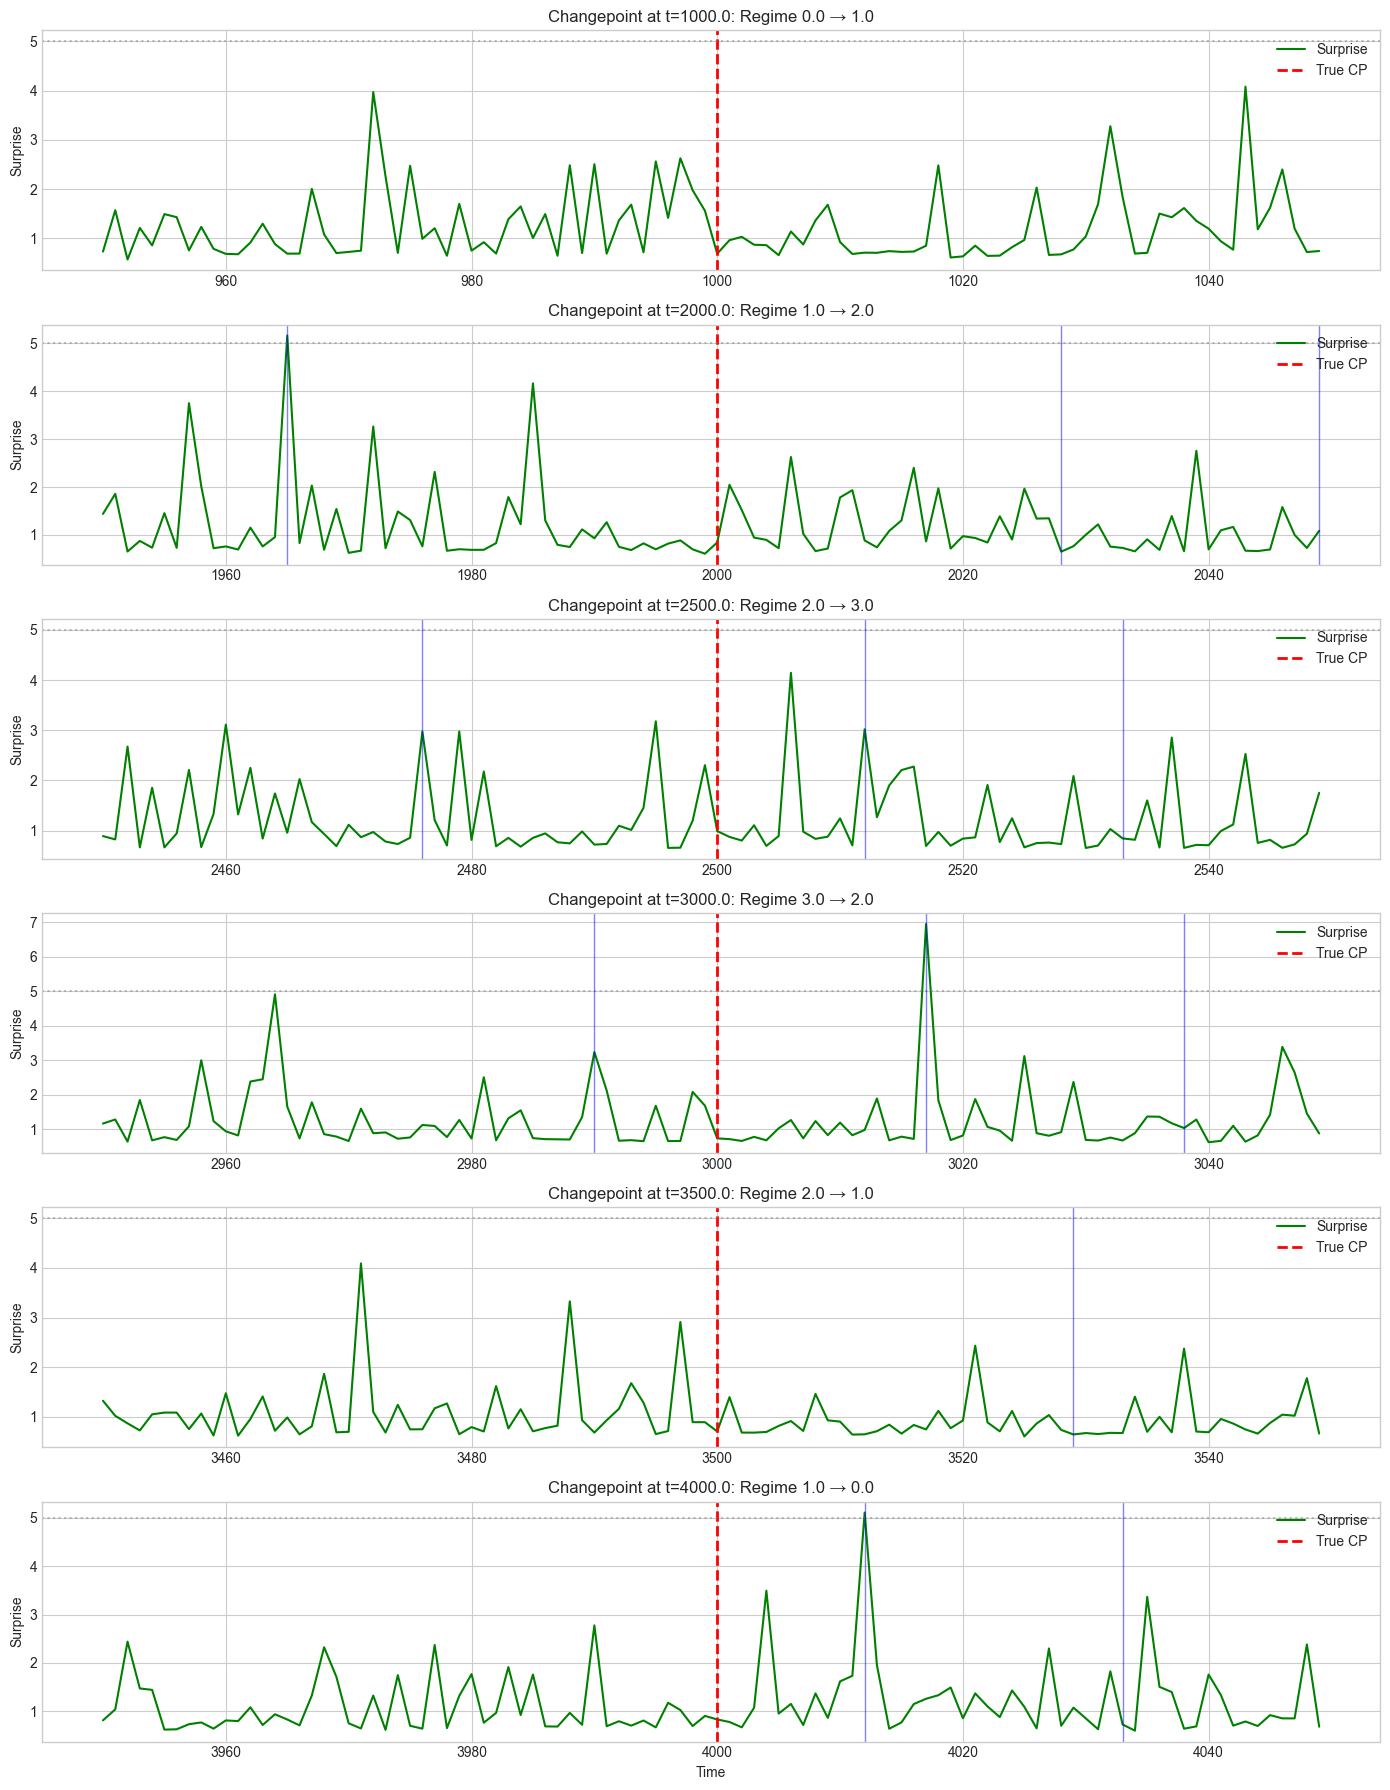

In [6]:
# Zoom into each changepoint
n_cp = len(cp_df)
if n_cp > 0:
    fig, axes = plt.subplots(n_cp, 1, figsize=(14, 3*n_cp))
    if n_cp == 1:
        axes = [axes]
    
    window = 50  # timesteps around changepoint
    
    for i, (idx, cp) in enumerate(cp_df.iterrows()):
        ax = axes[i]
        t_cp = cp['t']
        t_start = max(0, t_cp - window)
        t_end = min(len(df), t_cp + window)
        
        subset = df[(df['t'] >= t_start) & (df['t'] < t_end)]
        
        # Plot surprise around changepoint
        ax.plot(subset['t'], subset['surprise'], 'g-', linewidth=1.5, label='Surprise')
        ax.axvline(x=t_cp, color='red', linestyle='--', linewidth=2, label=f'True CP')
        ax.axhline(y=5, color='gray', linestyle=':', alpha=0.5)
        
        # Mark detected changes
        detected_times = subset[subset['detected'] == 1]['t']
        for dt in detected_times:
            ax.axvline(x=dt, color='blue', linestyle='-', alpha=0.5, linewidth=1)
        
        ax.set_title(f"Changepoint at t={t_cp}: Regime {cp['from_regime']} → {cp['to_regime']}")
        ax.set_ylabel('Surprise')
        ax.legend(loc='upper right')
    
    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.savefig('rbpf_diagnostic_changepoints.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. Error Analysis by Regime

In [7]:
# Compute errors by regime (using fast signal)
df['log_vol_error'] = df['est_log_vol_fast'] - df['true_log_vol']
df['vol_error'] = df['est_vol_fast'] - df['true_vol']
df['abs_log_vol_error'] = df['log_vol_error'].abs()
df['abs_vol_error'] = df['vol_error'].abs()

regime_stats = df.groupby('true_regime').agg({
    'abs_log_vol_error': ['mean', 'std', 'max'],
    'abs_vol_error': ['mean', 'std', 'max'],
    'surprise': ['mean', 'max'],
    'ess': ['mean', 'min'],
    't': 'count'
}).round(4)

regime_stats.columns = ['_'.join(col).strip() for col in regime_stats.columns.values]
regime_stats = regime_stats.rename(columns={'t_count': 'n_samples'})
print("Error Statistics by True Regime:")
regime_stats

Error Statistics by True Regime:


,abs_log_vol_error_mean,abs_log_vol_error_std,abs_log_vol_error_max,abs_vol_error_mean,abs_vol_error_std,abs_vol_error_max,surprise_mean,surprise_max,ess_mean,ess_min,n_samples
true_regime,,,,,,,,,,,
0,0.2011,0.1498,0.8648,0.0030,0.0026,0.0211,1.3375,8.6089,144.5952,57.1,2000
1,0.2198,0.1656,0.8583,0.0087,0.0079,0.0489,1.2356,9.2030,144.1656,42.0,1500
2,0.2873,0.2188,1.3162,0.0255,0.0212,0.1145,1.2024,6.9490,144.4411,49.4,1000
3,0.3262,0.2577,1.5084,0.0685,0.0665,0.5466,1.3228,4.9102,155.9786,43.9,500


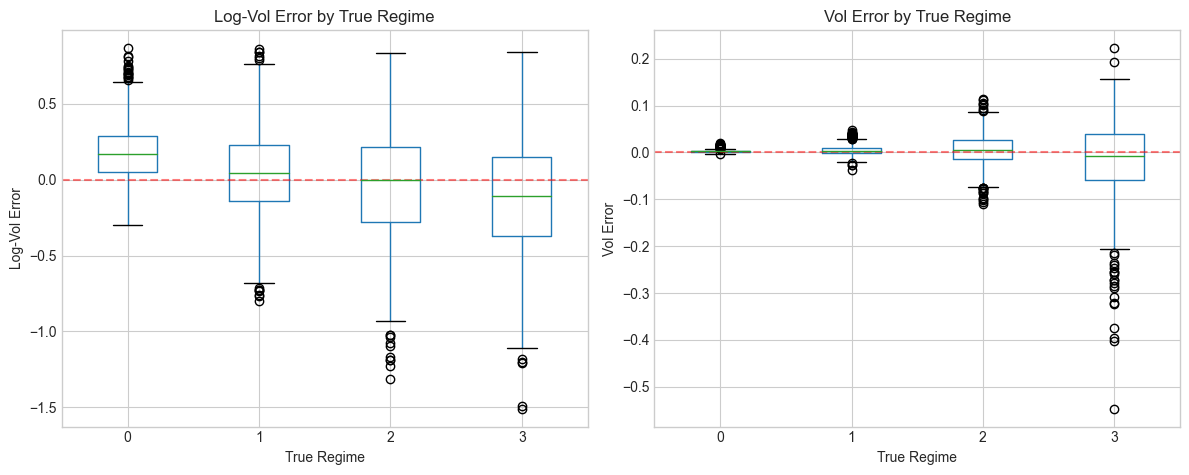

In [8]:
# Box plot of errors by regime
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Log-vol error
ax = axes[0]
df.boxplot(column='log_vol_error', by='true_regime', ax=ax)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Log-Vol Error by True Regime')
ax.set_xlabel('True Regime')
ax.set_ylabel('Log-Vol Error')

# Vol error
ax = axes[1]
df.boxplot(column='vol_error', by='true_regime', ax=ax)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Vol Error by True Regime')
ax.set_xlabel('True Regime')
ax.set_ylabel('Vol Error')

plt.suptitle('')  # Remove auto title
plt.tight_layout()
plt.savefig('rbpf_diagnostic_errors.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Regime Confusion Matrix

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion matrix (using fast signal)
cm_fast = confusion_matrix(df['true_regime'], df['est_regime_fast'])
cm_fast_normalized = cm_fast.astype('float') / cm_fast.sum(axis=1)[:, np.newaxis]

# Confusion matrix (using smooth signal)
cm_smooth = confusion_matrix(df['true_regime'], df['est_regime_smooth'])
cm_smooth_normalized = cm_smooth.astype('float') / cm_smooth.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Fast signal
sns.heatmap(cm_fast_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Med', 'High', 'Crisis'],
            yticklabels=['Low', 'Med', 'High', 'Crisis'])
axes[0].set_title('Regime Confusion Matrix (Fast Signal)')
axes[0].set_xlabel('Estimated Regime')
axes[0].set_ylabel('True Regime')

# Smooth signal
sns.heatmap(cm_smooth_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'Med', 'High', 'Crisis'],
            yticklabels=['Low', 'Med', 'High', 'Crisis'])
axes[1].set_title('Regime Confusion Matrix (Smooth Signal)')
axes[1].set_xlabel('Estimated Regime')
axes[1].set_ylabel('True Regime')

plt.tight_layout()
plt.savefig('rbpf_diagnostic_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClassification Report (Fast Signal):")
print(classification_report(df['true_regime'], df['est_regime_fast'],
                           target_names=['Low', 'Med', 'High', 'Crisis']))

print("\nClassification Report (Smooth Signal):")
print(classification_report(df['true_regime'], df['est_regime_smooth'],
                           target_names=['Low', 'Med', 'High', 'Crisis']))

ModuleNotFoundError: No module named 'sklearn'

## 6. Fast vs Smooth Comparison

In [ ]:
# Compare fast vs smooth signals
fast_correct = (df['true_regime'] == df['est_regime_fast']).sum()
smooth_correct = (df['true_regime'] == df['est_regime_smooth']).sum()
differ_count = (df['est_regime_fast'] != df['est_regime_smooth']).sum()

print(f"Fast regime accuracy:   {100 * fast_correct / len(df):.1f}%")
print(f"Smooth regime accuracy: {100 * smooth_correct / len(df):.1f}%")
print(f"Fast vs Smooth differ:  {100 * differ_count / len(df):.1f}% of ticks")

# Where do they differ?
differ_df = df[df['est_regime_fast'] != df['est_regime_smooth']]
if len(differ_df) > 0:
    print(f"\nWhen signals differ:")
    fast_correct_when_differ = (differ_df['true_regime'] == differ_df['est_regime_fast']).sum()
    smooth_correct_when_differ = (differ_df['true_regime'] == differ_df['est_regime_smooth']).sum()
    print(f"  Fast correct:  {100 * fast_correct_when_differ / len(differ_df):.1f}%")
    print(f"  Smooth correct: {100 * smooth_correct_when_differ / len(differ_df):.1f}%")

## 7. Summary Statistics

In [ ]:
print("=" * 60)
print("RBPF-KSC DIAGNOSTIC SUMMARY")
print("=" * 60)

# Overall accuracy (using fast signal)
vol_mae = df['abs_vol_error'].mean()
log_vol_mae = df['abs_log_vol_error'].mean()
correlation = df['true_vol'].corr(df['est_vol_fast'])
regime_accuracy_fast = (df['true_regime'] == df['est_regime_fast']).mean() * 100
regime_accuracy_smooth = (df['true_regime'] == df['est_regime_smooth']).mean() * 100

print(f"\nVolatility Tracking (Fast Signal):")
print(f"  MAE (vol):      {vol_mae:.4f}")
print(f"  MAE (log-vol):  {log_vol_mae:.4f}")
print(f"  Correlation:    {correlation:.4f}")

print(f"\nRegime Detection:")
print(f"  Fast accuracy:   {regime_accuracy_fast:.1f}%")
print(f"  Smooth accuracy: {regime_accuracy_smooth:.1f}%")

# Tail tracking (90th percentile of true vol)
p90_vol = df['true_vol'].quantile(0.90)
tail_df = df[df['true_vol'] > p90_vol]
tail_mae = tail_df['abs_vol_error'].mean()
tail_correlation = tail_df['true_vol'].corr(tail_df['est_vol_fast'])

print(f"\nTail Tracking (vol > {p90_vol:.4f}):")
print(f"  Tail MAE:       {tail_mae:.4f}")
print(f"  Tail Corr:      {tail_correlation:.4f}")
print(f"  Samples:        {len(tail_df)}")

# Changepoint detection
n_true_cp = len(cp_df)
n_detected = df['detected'].sum()
n_detected_near_true = sum(
    any(abs(df[df['detected'] == 1]['t'] - cp['t']) <= 10) 
    for _, cp in cp_df.iterrows()
) if len(cp_df) > 0 else 0

print(f"\nChangepoint Detection:")
print(f"  True changepoints:     {n_true_cp}")
print(f"  Detections (total):    {n_detected}")
print(f"  True positives:        {n_detected_near_true}")

# ESS health
print(f"\nESS Health:")
print(f"  Mean ESS:       {df['ess'].mean():.1f}")
print(f"  Min ESS:        {df['ess'].min():.1f}")
print(f"  ESS < 50%:      {(df['ess'] < df['ess'].max() * 0.5).sum()} samples")

print("\n" + "=" * 60)

## 8. Diagnosis & Recommendations

In [ ]:
print("DIAGNOSIS:")
print("-" * 40)

# Check regime tracking
if regime_accuracy_fast < 60:
    print("⚠ Low regime accuracy ({:.1f}%)".format(regime_accuracy_fast))
    print("  → Transition matrix may be too sticky")
    print("  → Or regime parameters don't match data")
else:
    print("✓ Regime accuracy OK ({:.1f}%)".format(regime_accuracy_fast))

# Check tail tracking
if tail_mae > vol_mae * 2:
    print("⚠ Poor tail tracking (tail MAE {:.4f} >> overall {:.4f})".format(tail_mae, vol_mae))
    print("  → Filter may be too conservative in high-vol regimes")
    print("  → Consider adjusting regime 2/3 parameters")
else:
    print("✓ Tail tracking OK (tail MAE {:.4f})".format(tail_mae))

# Check surprise at changepoints
if len(cp_df) > 0:
    mean_cp_surprise = cp_df['surprise'].mean()
    mean_overall_surprise = df['surprise'].mean()
    if mean_cp_surprise < mean_overall_surprise * 1.5:
        print("⚠ Low surprise at changepoints ({:.2f} vs {:.2f} overall)".format(
            mean_cp_surprise, mean_overall_surprise))
        print("  → Filter may not be detecting regime changes")
    else:
        print("✓ Surprise elevated at changepoints ({:.2f} vs {:.2f})".format(
            mean_cp_surprise, mean_overall_surprise))

# Check ESS
if df['ess'].min() < 20:
    print("⚠ ESS drops very low (min={:.1f})".format(df['ess'].min()))
    print("  → Particle degeneracy occurring")
    print("  → Consider increasing regularization")
else:
    print("✓ ESS healthy (min={:.1f})".format(df['ess'].min()))

# Fast vs Smooth recommendation
if regime_accuracy_smooth > regime_accuracy_fast + 2:
    print("✓ Smooth signal is more accurate - use for position sizing")
elif regime_accuracy_fast > regime_accuracy_smooth + 2:
    print("ℹ Fast signal is more accurate on this data")
else:
    print("ℹ Fast and Smooth signals have similar accuracy")